In [1]:
import csv
import cv2
import numpy as np

lines = []

with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [2]:
car_images = []
steering_angles = []
for row in lines[1:]:
    steering_center = float(row[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.25 # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    # read in images from center, left and right cameras
    path = './data/' # fill in the path to your training IMG directory
    #print(path + row[0].replace(" ", ""))
    #print(path + row[1].replace(" ", ""))
    #print(path + row[2].replace(" ", ""))
    
    img_center = cv2.imread(path + row[0].replace(" ", ""))
    img_center_fliped = np.fliplr(img_center)
    img_left = cv2.imread(path + row[1].replace(" ", ""))
    img_left_fliped = np.fliplr(img_left)
    img_right = cv2.imread(path + row[2].replace(" ", ""))
    img_right_fliped = np.fliplr(img_right)

    # add images and angles to data set
    car_images.extend([img_center, img_left, img_right, img_center_fliped, img_left_fliped, img_right_fliped])
    steering_angles.extend([steering_center, steering_left, steering_right, -1.0 * steering_center, -1.0 * steering_left, -1.0 * steering_right])

In [3]:
X_train = np.array(car_images)
y_train = np.array(steering_angles)

In [4]:
import keras
from keras import backend as K
from keras.models import *
from keras.layers import *

image_shape = car_images[0].shape

model = Sequential()
model.add(Lambda(lambda x: x / 225.0 - 0.5, input_shape=image_shape))
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(3,160,320)))
model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', lr=0.001)

Using TensorFlow backend.


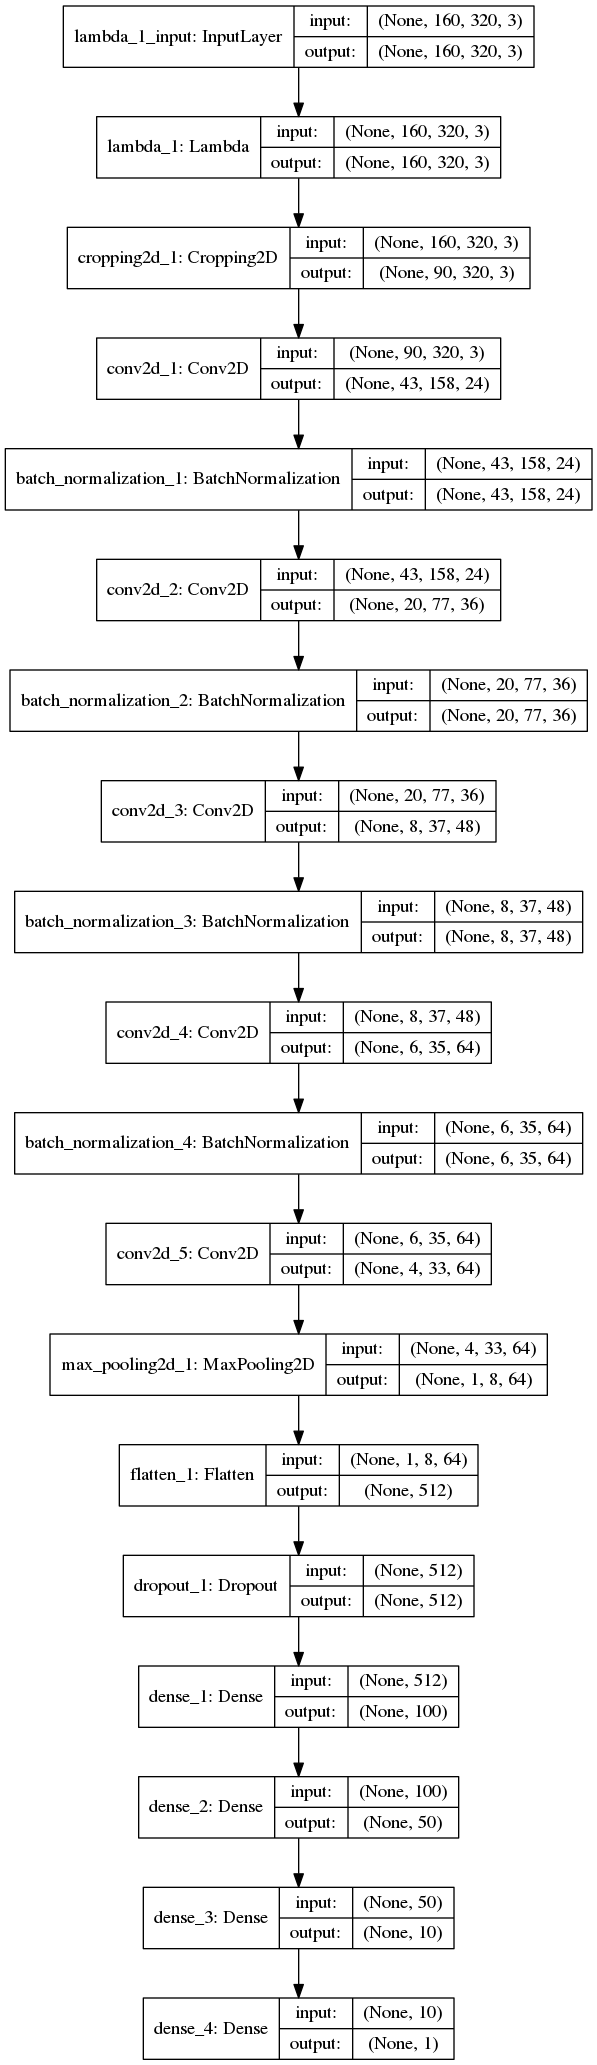

In [5]:
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plt.rcParams['figure.figsize'] = (3, 1)
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename = 'model.png')

In [6]:
from keras.models import Model, load_model
import matplotlib.pyplot as plt
#model = load_model('model.h5')

history_object = model.fit(X_train,
                           y_train,
                           batch_size=128,
                           validation_split=0.2,
                           epochs=15,
                           shuffle=True)

/home/meirtz/anaconda3/envs/dl_dev/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 38572 samples, validate on 9644 samples
Epoch 1/15
38572/38572 [==============================] - 44s - loss: 2.1945 - val_loss: 0.0740
Epoch 2/15
38572/38572 [==============================] - 43s - loss: 0.0648 - val_loss: 0.0346
Epoch 3/15
38572/38572 [==============================] - 43s - loss: 0.0415 - val_loss: 0.0349
Epoch 4/15
38572/38572 [==============================] - 42s - loss: 0.0329 - val_loss: 0.0298
Epoch 5/15
38572/38572 [==============================] - 43s - loss: 0.0287 - val_loss: 0.0286
Epoch 6/15
38572/38572 [==============================] - 42s - loss: 0.0259 - val_loss: 0.0282
Epoch 7/15
38572/38572 [==============================] - 43s - loss: 0.0242 - val_loss: 0.0274
Epoch 8/15
38572/38572 [==============================] - 42s - loss: 0.0229 - val_loss: 0.0277
Epoch 9/15
38572/38572 [==============================] - 43s - loss: 0.0217 - val_loss: 0.0263
Epoch 10/15
38572/38572 [==============================] - 43s - loss: 0.0211 - val_los

dict_keys(['loss', 'val_loss'])


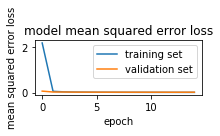

In [7]:
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [8]:
model.save('model.h5')